# Introduction

What would you do if you knew what everyone was thinking about you? Well, we're not quite there yet but we are gretting pretty close to it.  

Nowadays, people speak their mind across a lot of social media platforms and it is pretty amazing to see what they have to say about their experiences across various platforms. From Yelp reviews to your local pizza delivery service, people have a lot to talk about and give their thoughts on it. 


One of the best things that companies have taken advantage of this social media reviews is that they leverage these free (albeit no holds barred) isights to try and find things that keep the gears rolling smoother. 

With this, a platform that really takes a shining to all these insights goes to Twitter. With it's limited characters per tweet, you really can get some of the most creative responses within 280 characters.

As a result, one of the most interesting tweets comes from what people think about airline services. I mean, who wouldn't love going around in a giant metal tube all around the world? At the same time, there are some "mild" inconviences that occour that passengers  would love companies to look into.

This project highlights the sentiments that lie behind the airlines, focusing on what they can do better and at the same time, validate the sentimets that lie behind their ideas. Additionally, this project uses the fast.ai { formerly called the Universal Language Model Fine-tuning for Text Classification (ULMFiT) } to derrive and validate the senitment analysis. 



This research would not be possible without the help of some amazing people with their amazing ideas:

* Wesley Liao - https://www.kaggle.com/wesleyliao3/sentiment-analysis-using-rnn-lstm-ulmfit

* Yi Peng Neo - https://www.kaggle.com/neoyipeng2018/tweet-classification-using-awd-lstm

*   Yury Kashnitsky - https://www.kaggle.com/kashnitsky/clickbait-news-detection-ulmfit-starter



With credit given where credit is due, let us dive into the sentiments that go behind peoples' ideas.

### Load the libraries and Data

There was a bit of a depencey issue with notebooks, so Google Collab was a better option to load the package

In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
from sklearn.metrics import confusion_matrix, accuracy_score
import io
import os

In [0]:
from google.colab import files

uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


In [0]:
df = pd.read_csv(io.StringIO(uploaded['Tweets.csv'].decode('utf-8')))

Let's look at the basic framework of the data:

In [0]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Exploratory Data Analysis

It would be interesting to know what are the overall sentiments that people look at when taling about different airlines.  


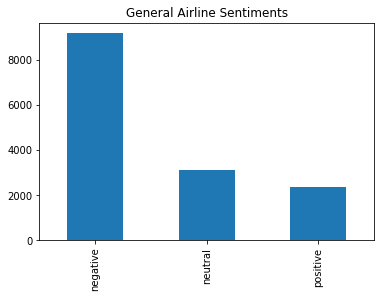

In [0]:
df['airline_sentiment'].value_counts().plot(kind='bar', title="General Airline Sentiments");

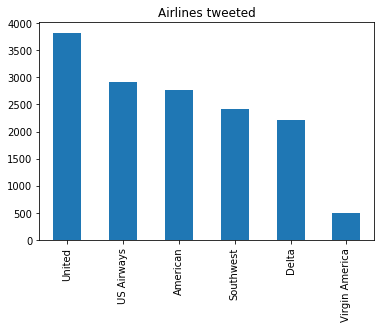

In [0]:
df['airline'].value_counts().plot(kind='bar',title="Airlines tweeted");

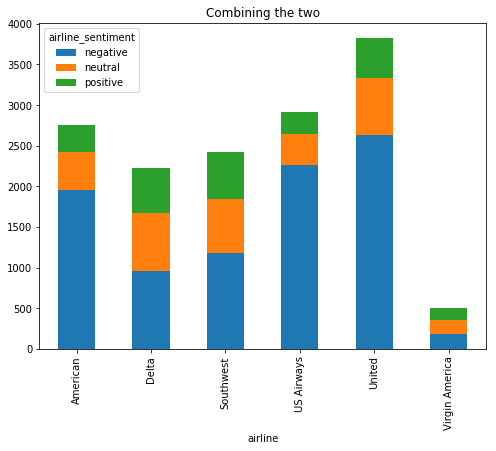

In [0]:
#Combining the two
df.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar', title="Combining the two",stacked=True,figsize=(8,6))

From the chart above,  a lot of people talk about United Airlines and are not too happy with it. Then again, there is a more negative outlook with most of the other airlines.  

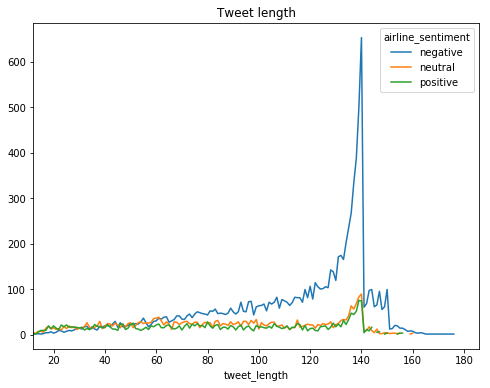

In [0]:
df['tweet_length'] = df['text'].apply(len)
df.groupby(['tweet_length', 'airline_sentiment']).size().unstack().plot(kind='line', title="Tweet length", stacked=False,figsize=(8,6))

People seem to be stronger with their words when writing a negative-worded tweet. Let's look at what seems to be the underlying issue going on with these airlines:

In [0]:
NR_Count = dict(df['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        NR_df=df
    else:
        NR_df=df[df['airline']==Airline]
    count=dict(NR_df['negativereason'].value_counts())
    Unique_reason=list(df['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

def plot_reason(Airline):
    NR_df=NR_Count(Airline)
    count=NR_df['count']
    Index = range(1,(len(NR_df)+1))
    plt.bar(Index,count)
    plt.xticks(Index,NR_df['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Reasons for Negative Reviews')

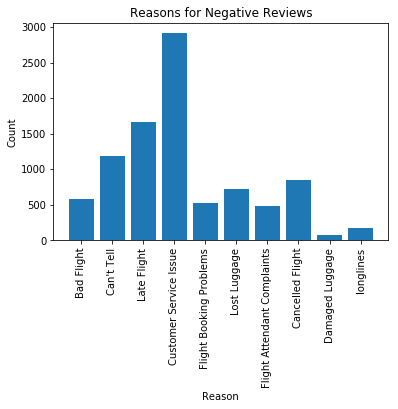

In [0]:
plot_reason('All')
plt.show()

### Feature Enigneering

Let us define the model to evaluate the given sentiments: 

In [0]:
data_model = df[['airline_sentiment','text']]
data_model.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [0]:
#Simple 80-20 split into train/validation set
train = data_model[:int(len(df)*.8)]
valid = data_model[int(len(df)*.8):]

test=data_model.sample(n=(int(len(df)*.2)))


In [0]:
data=TextClasDataBunch.from_df(path='.',train_df=train,valid_df=valid)
data.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup dub - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup dub 13 / 10 . i 'm * xxup g. xxmaj what is checked bag allowance for xxup jac - xxup lax ?,neutral
xxbos @usairways xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup bein xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! # seriously,negative
xxbos @usairways xxup fuk u xxup us xxup airways xxup with xxup yo xxup shitty xxup chicken xxup xxunk xxup sandwich xxup that xxup so xxup overpriced xxup and u xxup xxunk xxup make xxup me xxup wait xxup in a 6 xxup hr xxup layover xxup fuk u xxup and,negative
xxbos @united xxup fail xxmaj you xxmaj cancelled xxmaj flightled our flight frm xxup xxunk and then used our reserv home to xxup iah ( from xxup sea ) for reflight xxmaj booking xxmaj problems w / out xxup our xxup permission ! ! # xxup ph6rps,negative
"xxbos @united xxmaj waiting for xxunk xxup ewr - xxup ord , delayed 47 mins . xxmaj might miss xxunk xxup ord - xxup ywg at 6 pm xxup ct . xxmaj any room on xxunk xxup ord - xxup ywg in case i miss xxunk ?",negative


The word that can be seen in the beginning of evert tweet is a special token. The meaning behind these tokens are as shown below:



UNK (xxunk) is for an unknown word (one that isn't present in the current vocabulary)

PAD (xxpad) is the token used for padding, if we need to regroup several texts of different lengths in a batch

BOS (xxbos) represents the beginning of a text in your dataset

FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)

TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text

TK_UP (xxup) is used to indicate the next word is written in all caps in the original text

TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})

TK_WREP(xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

In [0]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

Let us define our batch size and seed values.

In [0]:
bs = 24
seed = 333

### Model Building

First we split the language model into and build a learner to see the basic outline of the model.

In [0]:
data_lm = TextLMDataBunch.from_df('.', train,valid)

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=1.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


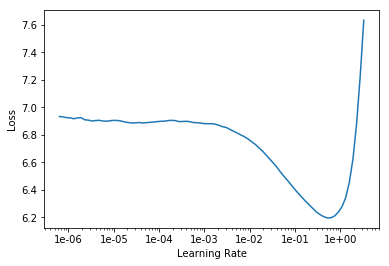

In [0]:
learn.lr_find()
learn.recorder.plot()

Next we work on a deep learning framework to observe the deelopment of the model. Since we used a Long Short Term Model (LSTM) framework, it makes it esier to freeze and unfreese the dimensions as we go through each layer.

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.872035,3.964833,0.272177,16:15


In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,3.801907,3.974261,0.268343,18:45
1,3.779525,3.951315,0.270746,18:43
2,3.752935,3.948955,0.271547,18:44


In [0]:
data_clas = (TextList.from_df(train,cols = 'text')      
             .random_split_by_pct(0.1, seed = seed)
             .label_from_df(cols=0)
             .databunch(bs=bs))
data_clas.save('data_clas.pkl')
data_clas.show_batch()

text,target
xxbos @united xxmaj hi have a question re future xxmaj flight xxmaj booking xxmaj problems . xxup xxunk - xxup jac 29 / 9 xxup jac - xxup lax 8 / 10 xxup lax - xxup xxunk 13 / 10 . i 'm * xxup xxunk xxmaj what is checked bag xxunk for xxup jac - xxup lax ?,neutral
xxbos @usairways xxup plans xxup changed ! xxup is xxup that xxup what u xxup call xxup not xxup xxunk xxup able 2 xxup park xxup on xxup time xxup planes w a 2 xxup hr xxup layover n b xxup able 2 xxup make xxup ur xxup connection ! # seriously,negative
"xxbos @united xxup xxunk from xxup ric , xxup xxunk from xxup ord , & & xxup xxunk from xxup den xxup xxunk xxup delayed for non - weather issues . xxmaj way to go , you re xxunk xxunk ! xxmaj but no hotels",negative
"xxbos @united xxmaj united xxmaj club team is xxup a+ & & got me a seat xxmaj late xxmaj flightr . xxmaj still , not sure why a last min xxup ual xxmaj cancelled xxmaj flightlation costs me $ yet overbooked folks get $ ?",negative
xxbos @usairways i left an item on plane xxup bos - xxup phl on xxmaj friday . i 've called xxup phl xxup us xxmaj airways # & & left 6 xxunk . xxmaj no return call what to do at this point .,negative


Now, we classify the text learner to observe the estimation of our sentiments.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


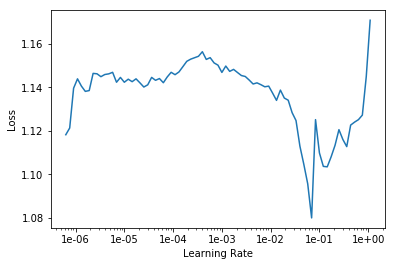

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.912387,0.938525,0.598634,07:27


In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.876493,0.877781,0.620837,09:38


In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.757549,0.735702,0.692570,17:48


In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.713893,0.636086,0.738685,27:31
1,0.726315,0.613646,0.760034,25:41
2,0.641450,0.578323,0.764304,27:17


Now, we apply our predicted model to our tweets and see if  there is an accuracy with the model provided.


In [0]:
test['pred_sentiment'] = test['text'].apply(lambda row: str(learn.predict(row)[0]))
print("Test Accuracy: ", accuracy_score(test['airline_sentiment'], test['pred_sentiment']))

Test Accuracy:  0.7872267759562842


This seems to be a fairly balanced prediction.  Let us observe a confusion matrix. This compares the variation between the precicted and the actual sentiment behind the tweet. This is useful to estimate the validity behind the sentiment. 

In [0]:
# Confusion matrix plotting adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

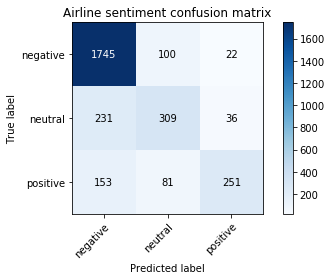

In [0]:
plot_confusion_matrix(test['airline_sentiment'], test['pred_sentiment'], classes=['negative', 'neutral', 'positive'], title='Airline sentiment confusion matrix')
# confusion_matrix(test['airline_sentiment'], test['pred_sentiment'], labels=['positive', 'neutral', 'negative'])
plt.show()

From this matrix, it can be observed that Negative tweets are predicted very accurately. However, neutral labels are predicted as negative. This is due to the disproportionate variation of data highlighing the negative aspect.

# Conclusion and Future Insights

Ultimately, this is a brief overview of the general idea that goes behind sentiment anlaysis. There is still a long way to go in terms of applying the sentiment analysi to a data-driven organization. For now, all we have is to sit back and enjoy our soaring expectations.


## Do Reach Out!

If you found something that catches your eye or just have a chat about data science topics in general, I will be more than happy to connect with you on:

LinkedIn: https://www.linkedin.com/in/shawn-dsouza/

My Website: https://shawndsouza29.wixsite.com/portfolio

This notebook will always be a work in progress. Please leave any comments about further improvements to the notebook! Any feedback or constructive criticism is greatly appreciated. Thank you guys!